In [ ]:
#Took out samples T85.1 and T85.3
biom convert -i /Users/dimitriosgiakoumas/Downloads/PERM2/Composition_Summary_L7_mvf_2.tsv -o /Users/dimitriosgiakoumas/Downloads/PERM2/Composition_Summary_L7_mvf_2.biom --table-type="OTU table" --to-hdf5

qiime tools import \
    --type 'FeatureTable[Frequency]' \
           --input-path /Users/dimitriosgiakoumas/Downloads/PERM2/Composition_Summary_L7_mvf_2.biom \
           --output-path /Users/dimitriosgiakoumas/Downloads/PERM2/Composition_Summary_L7_mvf_2.qza \
           --input-format BIOMV210Format

qiime diversity beta \
                --i-table /Users/dimitriosgiakoumas/Downloads/PERM2/Composition_Summary_L7_mvf_2.qza \
                --p-metric braycurtis \
                           --o-distance-matrix /Users/dimitriosgiakoumas/Downloads/PERM2/bray_curtis_distance_matrix_mvf_2.qza

qiime tools export \
            --input-path /Users/dimitriosgiakoumas/Downloads/PERM2/bray_curtis_distance_matrix_mvf_2.qza \
            --output-path /Users/dimitriosgiakoumas/Downloads/PERM2/bray_curtis_distance_matrix_mvf_2


PERMANOVA Results:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      23
number of groups                  2
test statistic             1.184608
p-value                        0.26
number of permutations          999
Name: PERMANOVA results, dtype: object

PERMDISP Results:
method name               PERMDISP
test statistic name        F-value
sample size                     23
number of groups                 2
test statistic            1.004484
p-value                      0.324
number of permutations         999
Name: PERMDISP results, dtype: object

Effect Size (R^2): 0.0534
Kruskal-Wallis test result: H-statistic = 6.7883748762795815, p-value = 0.033567819022928
Within Male vs Within Female: U-statistic = 5804.0, p-value = 0.007268661154964279
Within Male vs Between M-F: U-statistic = 6606.0, p-value = 0.22813070437822824
Within Female vs Between M-F: U-statistic = 9516.0, p-value = 0.19520241824240792


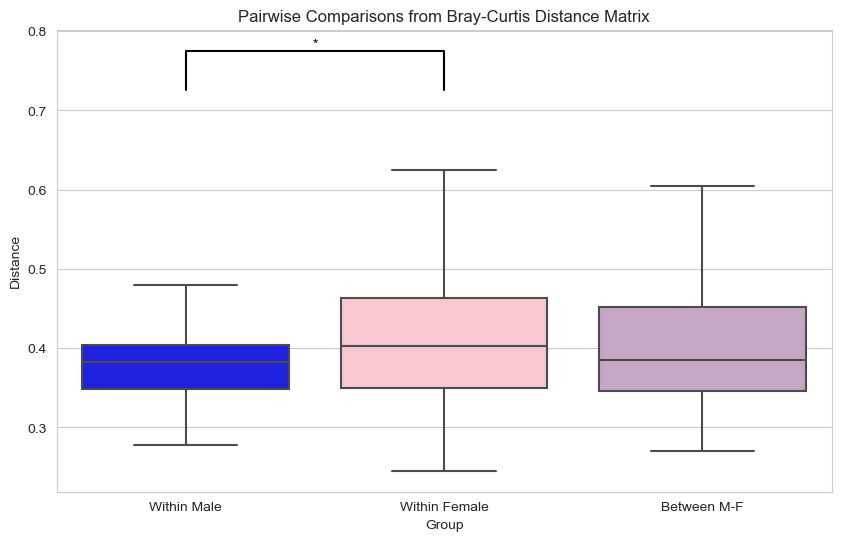

In [7]:
import pandas as pd
import numpy as np
from skbio.stats.distance import DistanceMatrix, permanova, permdisp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu

# Workaround for the np.float deprecation issue in seaborn
np.float = float

# Load data from a TSV file
data = pd.read_csv('/Users/dimitriosgiakoumas/Library/CloudStorage/OneDrive-FloridaAtlanticUniversity/PERM2/bray_curtis_distance_matrix_mvf_2/distance-matrix_mvf_2.tsv', sep='\t', index_col=0)
dist_matrix = DistanceMatrix(np.ascontiguousarray(data.values), ids=data.index.tolist())  # Ensure the data is C-contiguous

# Given sample IDs
male_samples = ["T20", "T107", "T203", "T212", "T99", "T195", "T205", "T160", "T216", "T209", "T16"]
female_samples = ["T11", "T85.2", "T65", "T196", "TAK", "T159", "TAA", "T4.1", "T214", "T136", "T17", "T217"]

# Create a grouping vector
group = ['male' if id in male_samples else 'female' if id in female_samples else 'unknown' for id in data.index]

# Perform PERMANOVA and PERMDISP
permanova_result = permanova(dist_matrix, group, permutations=999)
permdisp_result = permdisp(dist_matrix, group, permutations=999)

# Output the results
print("PERMANOVA Results:", permanova_result, "\nPERMDISP Results:", permdisp_result, sep='\n')

# Extract distances for visualization
def extract_distances(matrix, group1, group2):
    return [matrix.at[s1, s2] for s1 in group1 for s2 in group2 if s1 != s2]

within_male_distances = extract_distances(data, male_samples, male_samples)
within_female_distances = extract_distances(data, female_samples, female_samples)
between_mf_distances = extract_distances(data, male_samples, female_samples)

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Group': ['Within Male'] * len(within_male_distances) +
             ['Within Female'] * len(within_female_distances) +
             ['Between M-F'] * len(between_mf_distances),
    'Distance': within_male_distances + within_female_distances + between_mf_distances
})

# Ensure 'Distance' column is numeric
df['Distance'] = df['Distance'].astype(float)

# Export DataFrame to CSV for GraphPad Prism
df.to_csv('/Users/dimitriosgiakoumas/Library/CloudStorage/OneDrive-FloridaAtlanticUniversity/PERM2/bray_curtis_distances_for_prism2.csv', index=False)

# Calculate effect size (R^2)
SS_between = permanova_result['test statistic'] * (permanova_result['number of groups'] - 1)
SS_total = SS_between + (permanova_result['sample size'] - permanova_result['number of groups'])
R2 = SS_between / SS_total
print(f"\nEffect Size (R^2): {R2:.4f}")

# Statistical Tests
# Kruskal-Wallis Test for overall differences
kruskal_result = kruskal(within_male_distances, within_female_distances, between_mf_distances)
print(f"Kruskal-Wallis test result: H-statistic = {kruskal_result.statistic}, p-value = {kruskal_result.pvalue}")

# Pairwise Wilcoxon Rank-Sum Tests
pairwise_results = {
    'Within Male vs Within Female': mannwhitneyu(within_male_distances, within_female_distances),
    'Within Male vs Between M-F': mannwhitneyu(within_male_distances, between_mf_distances),
    'Within Female vs Between M-F': mannwhitneyu(within_female_distances, between_mf_distances)
}

for comparison, result in pairwise_results.items():
    print(f"{comparison}: U-statistic = {result.statistic}, p-value = {result.pvalue}")

# Define your color palette here
custom_palette = ['blue', 'pink', '#c8a2c8']  # Blue, Pink, Light Purple

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Group', y='Distance', hue='Group', data=df, palette=custom_palette, dodge=False)

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], ['Within Male', 'Within Female', 'Between M-F'], title='Group')

# Remove the hue legend since it's redundant
ax.get_legend().remove()

# Find the maximum distance for setting the height of significance bar
max_distance = df['Distance'].max()

# Function to add significance bars
def add_significance_bar(start, end, height, display_text, ax):
    ax.plot([start, start, end, end], [height, height + 0.05, height + 0.05, height], lw=1.5, c='black')
    ax.text((start + end) * .5, height + 0.05, display_text, ha='center', va='bottom', color='black')

# Add the significance bar at an appropriate height
# The height is set to max_distance + 0.1 (or more) to ensure it is above the highest boxplot
significance_height = max_distance + 0.1
add_significance_bar(start=0, end=1, height=significance_height, display_text='*', ax=ax)

plt.title('Pairwise Comparisons from Bray-Curtis Distance Matrix')
plt.show()

# Clean up the workaround
del np.float